In [1]:
import sys
sys.path.append(r'D:\CE7454_2018\VAE FOR STOCHASTIC INTEGER PROGRAMMING\CVAE for stochastic programming')
from local_stochoptim.stochprob.network_design import network_design_problem as ndp

In [2]:
import numpy as np
#import .local.stochoptim.stochprob.network_design.network_design_problem as ndp
import stochoptim.stochprob.network_design.network_design_solution as nds
import stochoptim.stochprob.network_design.network_design_uncertainty as ndu
from stochoptim.scenclust.cost_space_partition import CostSpaceScenarioPartitioning
import stochoptim.scengen.scenario_tree as st
np.set_printoptions(linewidth=120)

In [3]:
import os
import time
import torch
import argparse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Dataset, TensorDataset
from collections import defaultdict

# for VAE
from models_objs_gcn import VAE

# for clustering
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler

In [4]:
from config import *

### Generate Problem Parameters

In [5]:
n_origins = 2
n_destinations = 2
n_intermediates = 40
#------------
param = ndp.generate_random_parameters(n_origins, n_destinations, n_intermediates)
param

{'n_origins': 2,
 'n_destinations': 2,
 'n_intermediates': 40,
 'opening_cost': array([[ 5,  6,  3, ...,  6,  4,  8],
        [ 4, 10,  7, ...,  6,  6,  3],
        [10,  8,  9, ...,  9,  5,  9],
        ...,
        [ 5, 10,  4, ...,  5,  8,  9],
        [ 7,  6, 10, ...,  4,  7,  4],
        [ 3, 10,  9, ...,  5,  9,  5]]),
 'shipping_cost': array([[   9,    6,    5, ...,    7, 1000, 1000],
        [   7,    7,    7, ...,    5, 1000, 1000],
        [   6,    9,    9, ...,   10,    7,    9],
        ...,
        [   7,    8,   10, ...,    5,    8,    7],
        [   9,    5,    6, ...,    5,    6,   10],
        [   5,    5,    5, ...,    8,    9,    9]]),
 'capacity': array([[    21,     33,     13, ...,     32, 100000, 100000],
        [    14,     37,     28, ...,     28, 100000, 100000],
        [    40,     14,     11, ...,     13,     31,     31],
        ...,
        [    26,     17,     29, ...,     25,     12,     35],
        [    15,     25,     26, ...,     38,     27,    

### Instantiate Problem

In [6]:
network_problem = ndp.NetworkDesign(param)
network_problem

Network Design Problem: (2 stages)
  - decision variables: [1888, 7568]
    - stage 0: 
      - y: 1888 (b)
    - stage 1: 
      - z: 7568 (c)
  - random variables: [0, 4]
    - stage 1: 
      - d: 4

Network: 
  44 nodes
  1888 transportation arcs
  4 commodities

### Instantiate Uncertainty

#### Lognormal Demand

In [7]:
# n_scenarios = 200
# distribution = 'lognormal'
# mean = 1
# std = 1
# #------------------
# network_uncertainty = ndu.Demands(n_scenarios=n_scenarios, 
#                                   n_commodities=n_destinations*n_origins, 
#                                   distribution=distribution,
#                                   mean=mean, 
#                                   std=std)
# network_uncertainty

#### Uniform Demand

In [8]:
n_scenarios = 200
distribution = 'uniform'
lb = 5
ub = 20
corr = 0.4
#----------------
network_uncertainty = ndu.Demands(n_scenarios=n_scenarios,
                                  n_commodities=n_origins*n_destinations, 
                                  distribution=distribution,
                                  lb=lb, 
                                  ub=ub, 
                                  corr=corr)   
network_uncertainty

Commodity demand uncertainty: U[5,20]-corr0.4 
  - scenarios: 200 
  - features: 4 
    - d: 4 

### Build Original Scenario Tree (with all scenarios)

In [9]:
scenario_tree = network_uncertainty.get_scenario_tree()
scenario_tree.to_numpy()

array([[17, 17,  6, 17],
       [ 8, 13, 13, 11],
       [19, 15, 17, 14],
       [12, 18, 13, 18],
       [18, 19, 19, 13],
       [ 8, 16, 16,  8],
       [ 9, 18,  7, 18],
       [13,  5, 19,  8],
       [ 9, 18,  5, 10],
       [16,  8, 19,  5],
       [12, 12, 16, 14],
       [13, 18, 13, 15],
       [ 5,  7,  6,  7],
       [10, 20, 20,  6],
       [16,  6,  7, 14],
       [14, 14, 14, 17],
       [14, 14, 13, 18],
       [14,  8, 15, 15],
       [20, 12, 15, 16],
       [ 8, 14, 20, 17],
       [18,  7, 18, 19],
       [18,  7, 17, 16],
       [10,  9, 13,  6],
       [14,  8, 13, 13],
       [13, 19, 14, 15],
       [15, 19, 12, 15],
       [15,  8, 15, 15],
       [10, 19,  7, 19],
       [ 5, 20,  8, 15],
       [ 6, 12, 12, 12],
       [15, 10, 14,  6],
       [ 8, 13, 19, 11],
       [ 8, 17,  9,  6],
       [18, 10, 20, 19],
       [12,  9, 14,  5],
       [19, 14, 13,  9],
       [16, 15, 13, 15],
       [11,  7,  8,  6],
       [19,  9,  5, 18],
       [19, 19, 16, 14],


In [10]:
#scenario_tree.plot_scenarios('d')

# 1. Clustering with nets

In [11]:
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
config_path = "configs/tsp10.json"
config = get_config(config_path)
print("Loaded {}:\n{}".format(config_path, config))
# the net
vae = VAE(
    config=config,      
    encoder_layer_sizes=[4, 128],
    latent_size=2,
    decoder_layer_sizes=[128, 4],
    conditional=True,
    num_labels=2 if True else 0).to(device)

Loaded configs/tsp10.json:
{'expt_name': 'tsp10', 'gpu_id': '0', 'train_filepath': './data/tsp10_train_concorde.txt', 'val_filepath': './data/tsp10_val_concorde.txt', 'test_filepath': './data/tsp10_test_concorde.txt', 'num_nodes': 14, 'num_neighbors': -1, 'node_dim': 2, 'voc_nodes_in': 2, 'voc_nodes_out': 2, 'voc_edges_in': 3, 'voc_edges_out': 2, 'beam_size': 1280, 'hidden_dim': 128, 'num_layers': 30, 'mlp_layers': 3, 'aggregation': 'mean', 'max_epochs': 1500, 'val_every': 5, 'test_every': 100, 'batch_size': 20, 'batches_per_epoch': 500, 'accumulation_steps': 1, 'learning_rate': 0.001, 'decay_rate': 1.01}
CUDA available, using GPU ID 0


In [13]:
# Specify a path
PATH = "trained_nets/ob_saved_model_GCN_"+ str(700) + ".pt"
# load parameters
vae.load_state_dict(torch.load(PATH))
vae.eval()

VAE(
  (encoder): Encoder(
    (linear_means): Linear(in_features=128, out_features=2, bias=True)
    (linear_log_var): Linear(in_features=128, out_features=2, bias=True)
    (obj): Sequential(
      (L0): Linear(in_features=128, out_features=128, bias=True)
      (A0): ReLU()
    )
    (linear_obj): Linear(in_features=128, out_features=1, bias=True)
    (m_obj): Sigmoid()
  )
  (decoder): Decoder(
    (MLP): Sequential(
      (L0): Linear(in_features=4, out_features=128, bias=True)
      (A0): ReLU()
      (L1): Linear(in_features=128, out_features=4, bias=True)
      (sigmoid): Sigmoid()
    )
    (linear_dim_red): Linear(in_features=128, out_features=2, bias=True)
  )
  (GCN): ResidualGatedGCNModel(
    (nodes_coord_embedding): Linear(in_features=2, out_features=128, bias=False)
    (edges_values_embedding): Linear(in_features=3, out_features=64, bias=False)
    (edges_embedding): Embedding(3, 64)
    (gcn_layers): ModuleList(
      (0): ResidualGatedGCNLayer(
        (node_feat): N

In [14]:
ite = 5
bs = int(n_scenarios/ite)


tensor_c = torch.from_numpy(np.array([param['opening_cost'],param['shipping_cost'],param['capacity']]))
tensor_c = tensor_c.unsqueeze(0).repeat(bs, 1, 1, 1)
### notice! 0
tensor_c[tensor_c>999] = 0
tensor_c[tensor_c>99999] = 0
### notice! 20
# tensor_x = torch.from_numpy(scenario_tree.to_numpy()/20)
### 10 can be changed to any value > 1
# tensor_x = tensor_x.unsqueeze(1).repeat(1, 10, 1)
# x, y = tensor_x.to(device).float(), tensor_c.to(device).float() 
# recon_x, mean, log_var, z, target, objs, _, lat = vae(x, y)

z_list = []
with torch.no_grad():
    for ii in range(ite): 
        tensor_x = torch.from_numpy((scenario_tree.to_numpy()[ii*bs:(ii+1)*bs])/20)
        tensor_x = tensor_x.unsqueeze(1).repeat(1, 2, 1)
        x, y = tensor_x.to(device).float(), tensor_c.to(device).float() 
        recon_x, mean, log_var, z, target, objs, _, lat = vae(x, y)
        Xz = torch.cat((z,objs),1)        
        z_list.append(Xz)         
    z = torch.cat(z_list)

In [15]:
tracker_epoch = defaultdict(lambda: defaultdict(dict))

objs = z[:,2]/z[:,2].max()

for i, yi in enumerate(z):
    id = len(tracker_epoch)
    tracker_epoch[id]['x'] = z[i, 0].item()
    tracker_epoch[id]['y'] = z[i, 1].item()
    tracker_epoch[id]['Obj.'] = objs[i].item()

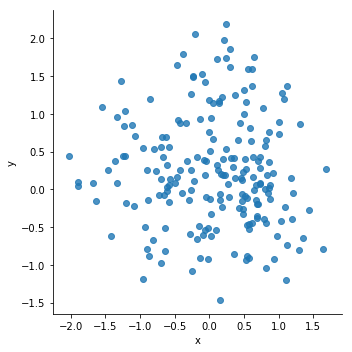

In [16]:
df = pd.DataFrame.from_dict(tracker_epoch, orient='index')
g = sns.lmplot(
    x='x', y='y', data=df,
    fit_reg=False, legend=True)

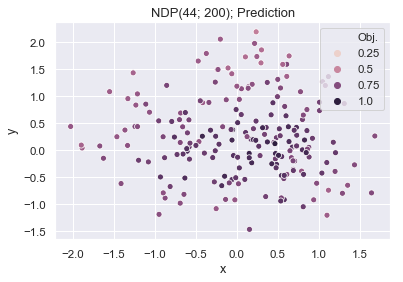

In [17]:
sns.set(font_scale = 1.05)
# pred = sns.scatterplot(data=df, x="x", y="y", hue="Obj.", legend="brief")
pred = sns.scatterplot(data=df, x="x", y="y", hue="Obj.", hue_norm=(0.25, 1), legend="brief")
pred.set_title('NDP(44; 200); Prediction', fontsize = 13, y =1);
plt.legend(loc='upper right')

In [18]:
pred.figure.savefig("images/predict_44_200.png")

In [19]:
X = torch.cat((z,objs),1).detach().cpu().numpy()
#X = objs.detach().cpu().numpy()
#X = z.detach().cpu().numpy()
#X = lat.detach().cpu().numpy()
kmedoids = KMedoids(n_clusters=2, random_state=0).fit(X)
kmedoids.labels_

array([0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1], dtype=int64)

In [20]:
repres =  kmedoids.cluster_centers_
repres

array([[-0.8691576 , -0.33217603,  0.58927244],
       [ 0.6746339 ,  0.10989577,  0.62875813]], dtype=float32)

In [21]:
indices= []
for j in range(repres.shape[0]):
    indices.append(np.where(np.all(X==repres[j], axis=1))[0][0])

In [22]:
scenario_tree.to_numpy()[np.array(indices)]

array([[12, 15, 10, 16],
       [16,  8, 15, 18]])

In [23]:
kmedoids.predict(repres)

array([0, 1], dtype=int64)

In [24]:
unique_elements, counts_elements = np.unique(kmedoids.labels_, return_counts=True)
print(unique_elements)
print(counts_elements/counts_elements.sum())

[0 1]
[0.415 0.585]


### Compute with representatives by nets

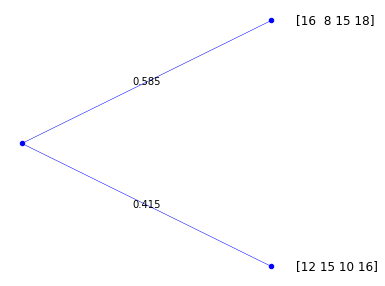

In [25]:
clustering_nets = st.twostage_from_scenarios(scenarios=scenario_tree.to_numpy()[np.array(indices)], 
                                                     n_rvar={'d': 4},
                                                     weights=np.array(counts_elements/counts_elements.sum()))
clustering_nets.plot_scenarios('d')

In [26]:
solution_clustering_nets = network_problem.solve(clustering_nets)
solution_clustering_nets

Number of scenario trees: 1 (bushiness: [2.0]) 

Initialize model... Finished. (0.182 sec).
Initialize variables... Finished. (0.005 sec).
Add deterministic constraints at subroot #1... Finished. (0.016 sec).
Define objective function at subtree #1... Finished. (0.015 sec).

Solve scenario tree #1... 
  Add random constraints at subtree #1... Finished. (0.017 sec).
  Solve problem at subtree #1... Finished. (3.742 sec).
  Fill scenario tree... Finished. (0.005 sec).
Finished. (3.770 sec).


obj=732.040, gap=0.001%, time=3.7 sec

C:\Users\WUYAOXIN\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


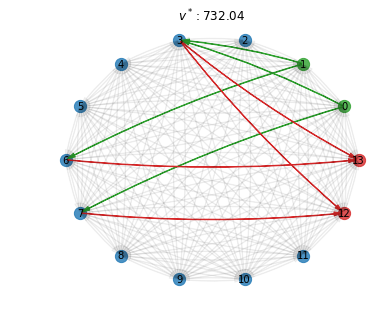

In [27]:
solution_clustering_nets.plot_network()

C:\Users\WUYAOXIN\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


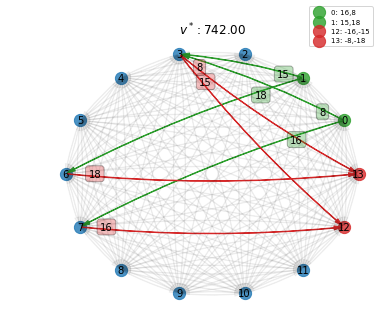

In [28]:
solution_clustering_nets.plot_network(scen_index=1)

### Evaluate the result by nets using the original scenario tree 

In [29]:
stage_0_decisions_nets = solution_clustering_nets.decision_process_fixed({0: ['y']})
stage_0_decisions_nets

Decision process: (2 stages)
  - decision variables: [178, 728]
    - stage 0: 
      - y: 178 (fixed: 178, callable: 0)
    - stage 1: 
      - z: 728

In [30]:
solution_nets = network_problem.solve(scenario_tree, 
                                         decision_process=stage_0_decisions_nets)
solution_nets

Number of scenario trees: 1 (bushiness: [200.0]) 

Problem is decomposed at stage 1 (200 subtrees).
Initialize model... Finished. (1.251 sec).
Initialize variables... Finished. (0.452 sec).
Add deterministic constraints at subroot #200... Finished. (2.076 sec).
Define objective function at subtree #200... Finished. (1.057 sec).

Solve scenario tree #1... 
  Add random constraints at subtree #200... Finished. (2.169 sec).
  Solve problem at subtree #200... Finished. (3.009 sec).
  Fill scenario tree... Finished. (0.195 sec).
Finished. (5.392 sec).


obj=755.470, gap=nan%, time=0.3 sec

C:\Users\WUYAOXIN\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


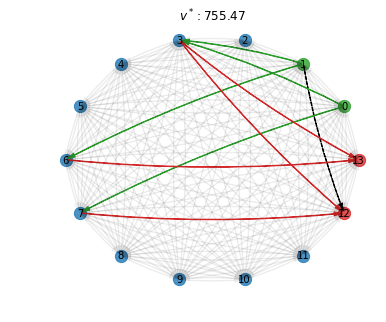

In [31]:
solution_nets.plot_network()

C:\Users\WUYAOXIN\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


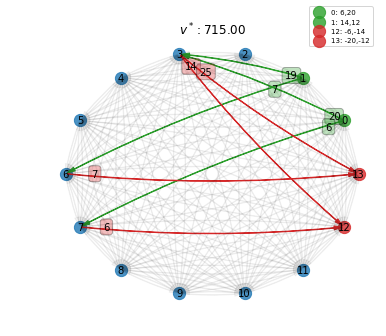

In [32]:
solution_nets.plot_network(scen_index=2)

# 2. K-medoids

In [33]:
# objs=[]
# for j in range(n_scenarios):
#     single_sce=st.twostage_from_scenarios(scenarios=scenario_tree.to_numpy()[j:j+1], 
#                                             n_rvar={'d': 4})            
#     actual_network_solution = network_problem.solve(single_sce, verbose=0)
#     objs.append(actual_network_solution.objective_value)        
# objs = np.array(objs)[:, np.newaxis]     

In [34]:
#KX = np.concatenate((objs, scenario_tree.to_numpy()), axis=1)
KX = scenario_tree.to_numpy()
scaler = StandardScaler()
scaler.fit(KX)
KX = scaler.transform(KX)
Kkmedoids = KMedoids(n_clusters=2, random_state=0).fit(KX)

In [35]:
Kkmedoids.labels_

array([0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0], dtype=int64)

In [36]:
Krepres =  Kkmedoids.cluster_centers_
Krepres

array([[ 0.56507303,  0.76159393,  0.49092864,  0.06262164],
       [-0.71192817, -0.74014058, -0.59519667,  0.06262164]])

In [37]:
Kindices= []
for j in range(Krepres.shape[0]):
    Kindices.append(np.where(np.all(KX==Krepres[j], axis=1))[0][0])

In [38]:
scenario_tree.to_numpy()[np.array(Kindices)]

array([[16, 17, 15, 13],
       [10, 10, 10, 13]])

In [39]:
Kunique_elements, Kcounts_elements = np.unique(Kkmedoids.labels_, return_counts=True)
print(Kunique_elements)
print(Kcounts_elements/Kcounts_elements.sum())

[0 1]
[0.55 0.45]


In [40]:
Kclustering_nets = st.twostage_from_scenarios(scenarios=scenario_tree.to_numpy()[np.array(Kindices)], 
                                                     n_rvar={'d': 4},
                                                     weights=np.array(Kcounts_elements/Kcounts_elements.sum()))

In [41]:
Ksolution_clustering_nets = network_problem.solve(Kclustering_nets)
Ksolution_clustering_nets

Number of scenario trees: 1 (bushiness: [2.0]) 

Initialize model... Finished. (0.008 sec).
Initialize variables... Finished. (0.004 sec).
Add deterministic constraints at subroot #1... Finished. (0.016 sec).
Define objective function at subtree #1... Finished. (0.016 sec).

Solve scenario tree #1... 
  Add random constraints at subtree #1... Finished. (0.039 sec).
  Solve problem at subtree #1... Finished. (0.090 sec).
  Fill scenario tree... Finished. (0.004 sec).
Finished. (0.136 sec).


obj=714.900, gap=0.000%, time=0.1 sec

In [42]:
Kstage_0_decisions_nets = Ksolution_clustering_nets.decision_process_fixed({0: ['y']})
Kstage_0_decisions_nets

Decision process: (2 stages)
  - decision variables: [178, 728]
    - stage 0: 
      - y: 178 (fixed: 178, callable: 0)
    - stage 1: 
      - z: 728

In [43]:
Ksolution_nets = network_problem.solve(scenario_tree, 
                                         decision_process=Kstage_0_decisions_nets)
Ksolution_nets

Number of scenario trees: 1 (bushiness: [200.0]) 

Problem is decomposed at stage 1 (200 subtrees).
Initialize model... Finished. (1.385 sec).
Initialize variables... Finished. (0.416 sec).
Add deterministic constraints at subroot #200... Finished. (1.991 sec).
Define objective function at subtree #200... Finished. (1.105 sec).

Solve scenario tree #1... 
  Add random constraints at subtree #200... Finished. (2.156 sec).
  Solve problem at subtree #200... Finished. (3.248 sec).
  Fill scenario tree... Finished. (0.215 sec).
Finished. (5.642 sec).


obj=755.470, gap=nan%, time=0.5 sec

C:\Users\WUYAOXIN\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


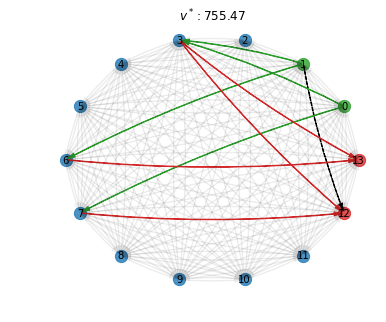

In [44]:
Ksolution_nets.plot_network()

# 3. Compute opportunity cost matrix

In [ ]:
opportunity_cost_matrix = network_problem.compute_opportunity_cost(scenario_tree, return_matrix=True, 
                                                                   relaxation_step1=True, relaxation_step2=True,
                                                                   verbose=0, logfile=None, decomposition=False)

Solve Wait-and-See Problems... Finished 4.646 sec
Evaluate Wait-and-See Solution #0... Finished 5.405 sec
Evaluate Wait-and-See Solution #1... 

In [46]:
np.round(opportunity_cost_matrix)

array([[  665.,   456., 13645., ...,  9452., 13665.,   563.],
       [17444.,   444., 28444., ..., 18344., 30444., 11406.],
       [ 1662.,   467.,   818., ...,  3533.,  8722.,   568.],
       ...,
       [15460.,  7358., 27452., ...,   552., 20542., 12396.],
       [  681.,   469.,  8726., ...,  1557.,   830.,   568.],
       [11526.,  3409., 20552., ..., 15393., 22552.,   552.]])

### Run Cost-Space-Scenario-Clustering (CSSC) Algorithm

In [47]:
cssc = CostSpaceScenarioPartitioning(opportunity_cost_matrix)

In [48]:
cssc.solve_mip(cardinality=2)

In [49]:
cssc.solution_mip

{'partition': ((0,
   1,
   2,
   3,
   4,
   5,
   6,
   8,
   9,
   10,
   11,
   12,
   14,
   15,
   16,
   19,
   21,
   23,
   24,
   26,
   28,
   30,
   31,
   32,
   34,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   47,
   50,
   52,
   53,
   54,
   56,
   57,
   58,
   59,
   60,
   61,
   63,
   64,
   65,
   67,
   68,
   69,
   70,
   73,
   74,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   97,
   98,
   100,
   101,
   102,
   103,
   107,
   108,
   110,
   111,
   112,
   113,
   116,
   119,
   120,
   121,
   122,
   123,
   124,
   125,
   126,
   127,
   128,
   129,
   130,
   131,
   132,
   133,
   137,
   139,
   140,
   141,
   142,
   146,
   147,
   148,
   150,
   151,
   152,
   154,
   155,
   157,
   158,
   161,
   162,
   164,
   167,
   168,
   169,
   170,
   172,
   174,
   176,
   177,
   178,
   179,
   182,
   184,
   185,
   186,
   187,
   190

### Build Approximate Scenario Tree (with the clustered scenarios)

In [50]:
clustered_scenarios = scenario_tree.to_numpy()[cssc.solution_mip['representatives'], :]
clustered_scenarios

array([[17, 20, 20, 13],
       [19, 14, 17, 18]])

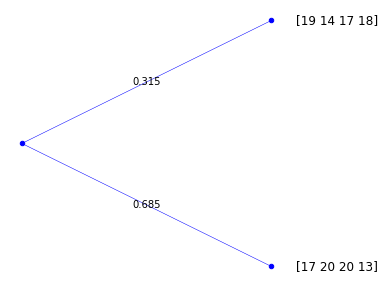

In [51]:
clustered_scenario_tree = st.twostage_from_scenarios(scenarios=clustered_scenarios, 
                                                     n_rvar={'d': 4},
                                                     weights=cssc.solution_mip['weights'])
clustered_scenario_tree.plot_scenarios('d')

### Solve the problem on the clustered scenario tree

In [52]:
network_solution_clustering = network_problem.solve(clustered_scenario_tree)
network_solution_clustering

Number of scenario trees: 1 (bushiness: [2.0]) 

Initialize model... Finished. (0.008 sec).
Initialize variables... Finished. (0.005 sec).
Add deterministic constraints at subroot #1... Finished. (0.016 sec).
Define objective function at subtree #1... Finished. (0.022 sec).

Solve scenario tree #1... 
  Add random constraints at subtree #1... Finished. (0.016 sec).
  Solve problem at subtree #1... Finished. (0.082 sec).
  Fill scenario tree... Finished. (0.004 sec).
Finished. (0.107 sec).


obj=911.975, gap=0.000%, time=0.1 sec

### Evaluate the stage-0 decisions using the original scenario tree 

In [53]:
# This is a decision process, i.e., an object that freezes some decisions in the problem before solving it.
# Here we freeze the stage-0 decisions and we will optimize only over the stage-1 decisions.
stage_0_decisions = network_solution_clustering.decision_process_fixed({0: ['y']})
stage_0_decisions

Decision process: (2 stages)
  - decision variables: [178, 728]
    - stage 0: 
      - y: 178 (fixed: 178, callable: 0)
    - stage 1: 
      - z: 728

In [54]:
network_solution = network_problem.solve(scenario_tree, 
                                         decision_process=stage_0_decisions)
network_solution

Number of scenario trees: 1 (bushiness: [200.0]) 

Problem is decomposed at stage 1 (200 subtrees).
Initialize model... Finished. (1.097 sec).
Initialize variables... Finished. (0.444 sec).
Add deterministic constraints at subroot #200... Finished. (2.092 sec).
Define objective function at subtree #200... Finished. (1.052 sec).

Solve scenario tree #1... 
  Add random constraints at subtree #200... Finished. (2.291 sec).
  Solve problem at subtree #200... Finished. (3.180 sec).
  Fill scenario tree... Finished. (0.225 sec).
Finished. (5.712 sec).


obj=713.975, gap=nan%, time=0.3 sec

### Plot solution

C:\Users\WUYAOXIN\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


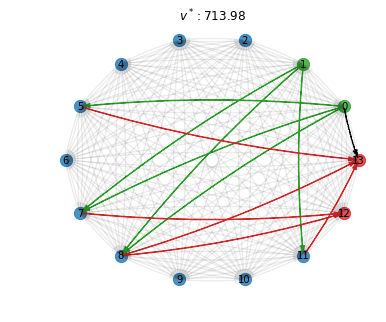

In [55]:
network_solution.plot_network()

C:\Users\WUYAOXIN\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


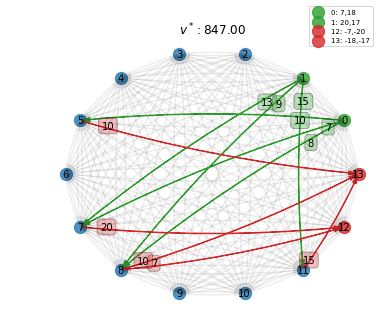

In [56]:
network_solution.plot_network(scen_index=2)

# 4. Compare with actual optimal solution

In [45]:
actual_network_solution = network_problem.solve(scenario_tree)
actual_network_solution

Number of scenario trees: 1 (bushiness: [200.0]) 

Initialize model... Finished. (0.009 sec).
Initialize variables... Finished. (0.324 sec).
Add deterministic constraints at subroot #1... Finished. (1.908 sec).
Define objective function at subtree #1... Finished. (1.285 sec).

Solve scenario tree #1... 
  Add random constraints at subtree #1... Finished. (1.565 sec).
  Solve problem at subtree #1... Finished. (31.455 sec).
  Fill scenario tree... Finished. (0.345 sec).
Finished. (33.370 sec).


obj=605.015, gap=0.870%, time=31.2 sec

C:\Users\WUYAOXIN\AppData\Local\Continuum\miniconda3\envs\deeplearn_course\lib\site-packages\matplotlib\figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


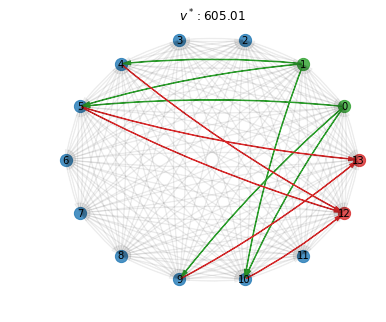

In [46]:
actual_network_solution.plot_network()

# 4. Show objective landscape

In [19]:
objs = []
for j in range(n_scenarios): 
    single_sce=st.twostage_from_scenarios(scenarios=scenario_tree.to_numpy()[j:j+1], 
                                            n_rvar={'d': 4})  
    actual_network_solution = network_problem.solve(single_sce, verbose=0)       
    objs.append(actual_network_solution.objective_value)     
objs = np.array(objs)

In [20]:
objs = objs/objs.max()

In [21]:
tracker_epoch = defaultdict(lambda: defaultdict(dict))
for i, yi in enumerate(z):
    id = len(tracker_epoch)
    tracker_epoch[id]['x'] = z[i, 0].item()
    tracker_epoch[id]['y'] = z[i, 1].item()
    tracker_epoch[id]['Obj.'] = objs[i]#z[i, 2].item()

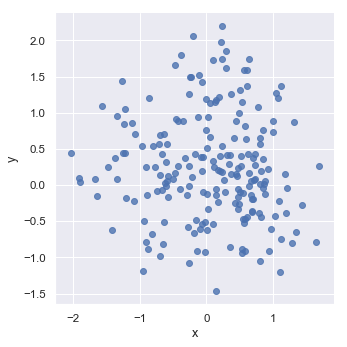

In [22]:
df = pd.DataFrame.from_dict(tracker_epoch, orient='index')
g = sns.lmplot(
    x='x', y='y', data=df,
    fit_reg=False, legend=True)

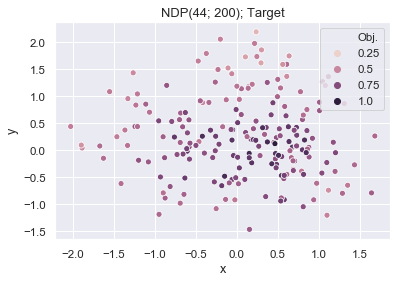

In [23]:
sns.set(font_scale = 1.05)
# target = sns.scatterplot(data=df, x="x", y="y", hue="Obj.", legend="brief")
target = sns.scatterplot(data=df, x="x", y="y", hue="Obj.", hue_norm=(0.25, 1), legend="brief")
target.set_title('NDP(44; 200); Target', fontsize = 13, y =1);
plt.legend(loc='upper right')

In [24]:
target.figure.savefig("images/target_44_200.png")